# Predicting Multi-MNIST digits.

The assignment consists of three tasks:

1. A multi-class classification problem: the prediction of grayscale images of double-digit numbers from a custom version of the (Multi-)MNIST dataset.

2. Unsupervised problem: the implementation of an AutoEncoder model for the encoding and reconstruction of the provided data.

3. You can choose between (one of them is mandatory, you can choose which one to do):

*   Use latent representation of autoencoder as a feature reduction
*   Explain Neural Network predictions


The dataset is created by simply concatenating pairs of MNIST digits, and the number of classes (originally all the numbers in the [0, 100] range) has been reduced.

An example of the provided dataset is the following:

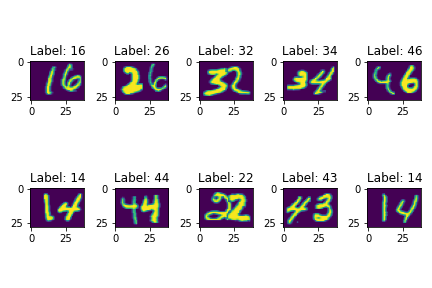

The provided data comprises the training set that can be used for the training (and for the validation) and the test set.

**General considerations**

Always describe and give proper motivations about the choices made during the assignment, including (but not limited to)

- data processing,
- network design: including number and dimension of the layers, regularization techniques (when requested).
- optimization algorithms, including hyperameters and criterions,
- model training hyperparameters
- loss/metric curves
- final evaluations and comparisons.


**Note**: Make sure that the outputs in the notebook cells are still visible once the notebook is exported (especially for html embeddings)

**Note**: Make sure that the submitted *.zip archives are not corrupted.

**Note**: convolutional layers should not be used all over this notebook (with the exception of the optional part).

## Inspecting the data

any comment about data dimensionality/distribution goes here

x_train shape: (72247, 28, 39) (Training samples, Height, Width)
y_train shape: (72247,) (Training labels)
x_test shape: (24083, 28, 39) (Test samples, Height, Width)
y_test shape: (24083,) (Test labels)

Training Class Distribution:
Label 1: 2282 samples
Label 2: 292 samples
Label 3: 2049 samples
Label 4: 1941 samples
Label 5: 1819 samples
Label 6: 641 samples
Label 7: 2102 samples
Label 8: 560 samples
Label 9: 2046 samples
Label 10: 2311 samples
Label 11: 2548 samples
Label 12: 766 samples
Label 13: 358 samples
Label 14: 634 samples
Label 15: 2055 samples
Label 16: 2214 samples
Label 17: 318 samples
Label 18: 471 samples
Label 19: 2403 samples
Label 20: 1982 samples
Label 21: 646 samples
Label 22: 2029 samples
Label 23: 2073 samples
Label 24: 413 samples
Label 25: 555 samples
Label 26: 2034 samples
Label 27: 2132 samples
Label 28: 1926 samples
Label 29: 1979 samples
Label 30: 276 samples
Label 31: 787 samples
Label 32: 832 samples
Label 33: 2159 samples
Label 34: 2050 samples
Label 3

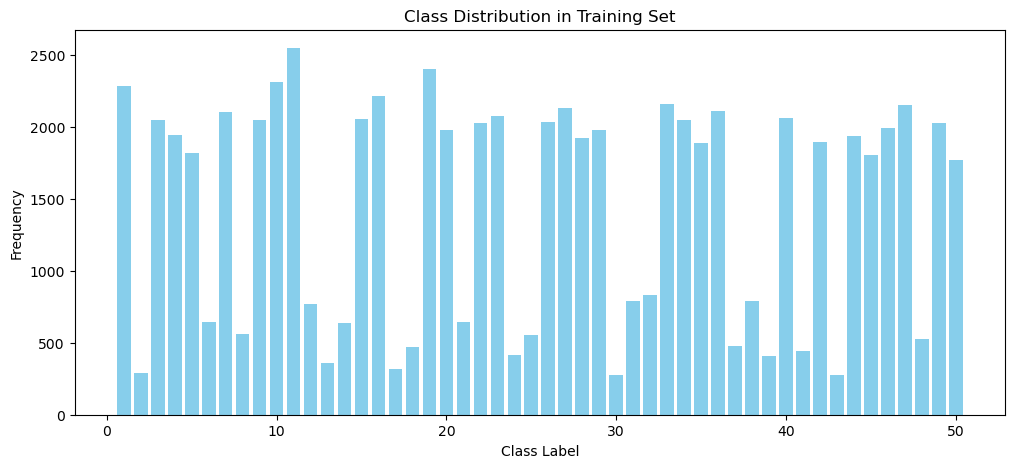


Pixel Value Statistics for Training Set:
Mean pixel value: 45.94
Standard deviation of pixel values: 86.29
Min pixel value: 0
Max pixel value: 255

Unique image shapes in the training set: {(28, 39)}

Unique labels in training set: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Number of unique labels: 50


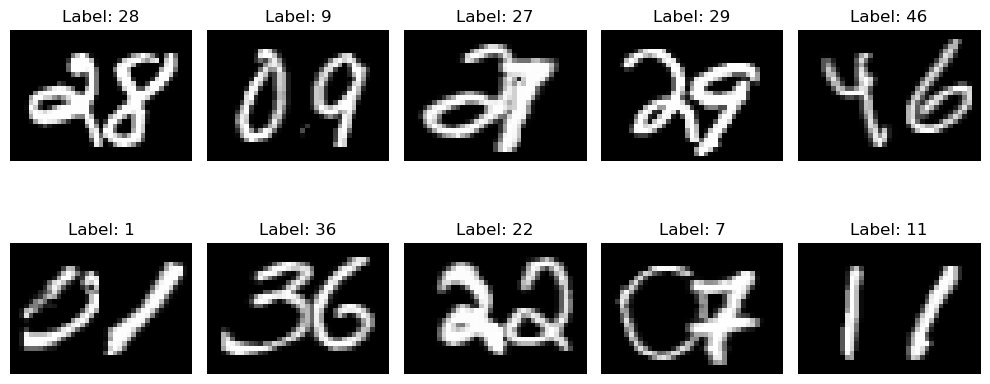

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the training and testing datasets
x_train = np.load("./x_train.npy")
x_test = np.load("./x_test.npy")
y_train = np.load("./y_train.npy")
y_test = np.load("./y_test.npy")

# Display the shapes of the training and testing datasets
print(f"x_train shape: {x_train.shape} (Training samples, Height, Width)")
print(f"y_train shape: {y_train.shape} (Training labels)")
print(f"x_test shape: {x_test.shape} (Test samples, Height, Width)")
print(f"y_test shape: {y_test.shape} (Test labels)")

# Compute the distribution of class labels in both training and testing datasets
train_class_distribution = Counter(y_train)
test_class_distribution = Counter(y_test)

# Display the class distribution in the training dataset
print("\nTraining Class Distribution:")
for label, count in sorted(train_class_distribution.items()):
    print(f"Label {label}: {count} samples")

# Display the class distribution in the testing dataset
print("\nTest Class Distribution:")
for label, count in sorted(test_class_distribution.items()):
    print(f"Label {label}: {count} samples")

# Plot the class distribution in the training dataset
plt.figure(figsize=(12, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values(), color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Set")
plt.show()

# Display pixel value statistics for the training set
print("\nPixel Value Statistics for Training Set:")
print(f"Mean pixel value: {np.mean(x_train):.2f}")
print(f"Standard deviation of pixel values: {np.std(x_train):.2f}")
print(f"Min pixel value: {np.min(x_train)}")
print(f"Max pixel value: {np.max(x_train)}")

# Identify unique image shapes in the training dataset
unique_shapes = {img.shape for img in x_train}
print("\nUnique image shapes in the training set:", unique_shapes)

# Identify unique class labels in the training dataset
unique_labels = np.unique(y_train)
print("\nUnique labels in training set:", unique_labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Visualize a subset of images from the training dataset with their respective labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

In [14]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# Normalize the pixel values to the range [0, 1] by dividing by 255.0
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the images from 2D (28, 39) to 1D (28*39)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Display the maximum value in the training and testing labels
print(f"Max value in y_train: {np.max(y_train)}")
print(f"Max value in y_test: {np.max(y_test)}")

# If the maximum value in the labels is 50, we need to correct this (if 50 represents an extra class)
if np.max(y_train) == 50:
    y_train = np.clip(y_train, 0, 49)  # Limit the labels to the range 0-49
    y_test = np.clip(y_test, 0, 49)  # Limit the labels to the range 0-49

# Apply one-hot encoding to the labels for multi-class classification
num_classes = 50  # We know there are 50 classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Print the new shapes to confirm that the preprocessing was performed correctly
print(f"Normalized and reshaped x_train shape: {x_train.shape}")
print(f"Normalized and reshaped x_test shape: {x_test.shape}")
print(f"One-hot encoded y_train shape: {y_train.shape}")
print(f"One-hot encoded y_test shape: {y_test.shape}")

Max value in y_train: 50
Max value in y_test: 50
Normalized and reshaped x_train shape: (72247, 1092)
Normalized and reshaped x_test shape: (24083, 1092)
One-hot encoded y_train shape: (72247, 50)
One-hot encoded y_test shape: (24083, 50)


# 1. The resolution of the problem of supervised classification with traditional fully-connected neural networks. [Mandatory]





You are required to implement two models, without and with the use of one (or more) regularization technique of your choice, and to compare their behaviours, in terms of training dynamics and generalization capabilities.

## 1.1 Non-regularized Model

In this section, you are required to attempt to solve the classification task with the implementation and training of a standard fully-connected Neural Network, without the use of any specific regularization technique.

### 1.1.1 Building the network


any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. loss/optimizer choice, final activations, loss functions, training metrics and training hyperparameters)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Create the model
model = Sequential()

# Define the input layer explicitly with the appropriate input shape
model.add(Input(shape=(1092,)))  # The input has a dimensionality of 1092

# First dense layer (hidden layer) with ReLU activation
model.add(Dense(512, activation='relu'))

# Second dense layer (hidden layer) with ReLU activation
model.add(Dense(256, activation='relu'))

# Third dense layer (hidden layer) with ReLU activation
model.add(Dense(128, activation='relu'))

# Fourth dense layer (hidden layer) with ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer with softmax activation for multi-class classification
model.add(Dense(50, activation='softmax'))  # 50 classes for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric: accuracy
)

# Display the model summary to review its architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │       559,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,346 (2.81 MB)

 Trainable params: 735,346 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

### 1.1.2 Analyze and comment on thetraining results

Describe, visualize and interpret the training history and the resulting training dynamics.

Epoch 25/25 - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9498 - val_loss: 0.3182

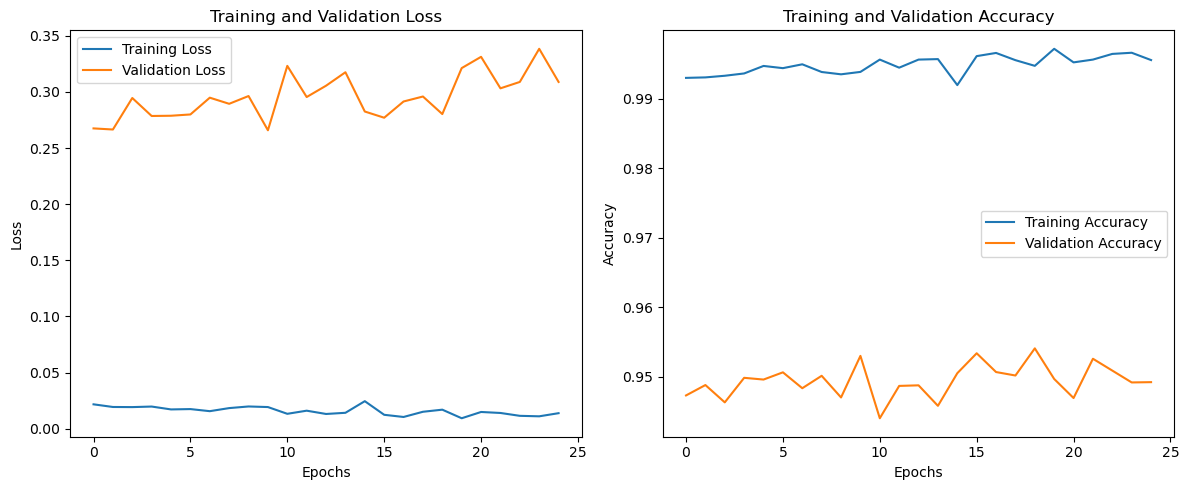

Training completed! Below, we summarize the results of the training process:
Final training accuracy: 0.9955
Final validation accuracy: 0.9492
Final training loss: 0.0139
Final validation loss: 0.3089


In [17]:
import matplotlib.pyplot as plt

# Define a custom progress bar class (similar to the previous example)
from tensorflow.keras.callbacks import Callback

class ProgressBar(Callback):
    """
    A custom callback that displays a rolling average of metrics (e.g., loss, accuracy) at the end of each epoch.
    
    This class is used to provide a smoother display of the metrics during training by computing 
    a rolling average over a defined window of epochs.
    
    Attributes:
    ----------
    rolling_window : int
        The number of recent epochs over which to compute the rolling average.
    metrics_history : dict
        A dictionary that stores the history of the metrics for each metric name.
    """
    
    def __init__(self, rolling_window=5):
        """
        Initializes the ProgressBar with a specified rolling window size.
        
        Parameters:
        -----------
        rolling_window : int, optional
            The number of epochs to consider for the rolling average. Default is 5.
        """
        super(ProgressBar, self).__init__()
        self.rolling_window = rolling_window
        self.metrics_history = {}

    def on_epoch_begin(self, epoch, logs=None):
        """
        This method is called at the start of each epoch. It records the current epoch number.
        
        Parameters:
        -----------
        epoch : int
            The index of the epoch to be started.
        logs : dict, optional
            A dictionary that holds the logs for the epoch.
        """
        self.epoch = epoch

    def _get_rolling_average(self, metric_name, current_value):
        """
        Computes the rolling average of a given metric over the specified window.
        
        This method stores the current value of the metric, maintains a history of the values,
        and computes the average over the most recent values within the rolling window.
        
        Parameters:
        -----------
        metric_name : str
            The name of the metric (e.g., 'accuracy', 'loss').
        current_value : float
            The current value of the metric for the epoch.
        
        Returns:
        --------
        float
            The rolling average of the metric over the defined window.
        """
        if metric_name not in self.metrics_history:
            self.metrics_history[metric_name] = []

        history = self.metrics_history[metric_name]
        history.append(current_value)

        # Ensure the history doesn't exceed the size of the rolling window
        if len(history) > self.rolling_window:
            history.pop(0)

        return sum(history) / len(history)

    def on_epoch_end(self, epoch, logs=None):
        """
        This method is called at the end of each epoch. It computes and prints the rolling average
        of the metrics for the epoch, formatted for display.
        
        Parameters:
        -----------
        epoch : int
            The index of the completed epoch.
        logs : dict, optional
            A dictionary containing the logs for the epoch.
        """
        metrics = []
        for metric_name, value in logs.items():
            avg_value = self._get_rolling_average(metric_name, value)
            metrics.append(f"{metric_name}: {avg_value:.4f}")

        # Display the progress for the current epoch with the rolling averages
        print(f"\rEpoch {self.epoch + 1}/{self.params['epochs']} - " +
              " - ".join(metrics), end='')


# Set training parameters (batch size, number of epochs)
batch_size = 256
epochs = 25  # Increase the number of epochs if necessary

# Train the model without regularization
history = model.fit(
    x_train, y_train,  # Training data and corresponding labels
    validation_data=(x_test, y_test),  # Validation data and labels
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=[ProgressBar(rolling_window=5)],  # Custom progress bar callback
    verbose=0,  # 0 means no output will be shown during training
    shuffle=True,  # Shuffle the data at the start of each epoch
)

# Visualize the loss and accuracy curves during training
plt.figure(figsize=(12, 5))

# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Summarize and comment on the training results
print("Training completed! Below, we summarize the results of the training process:")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

### 1.1.3 Validate the model and comment on the results

please describe and interpret the evaluation procedure on a **validation set**, including initial comments on the generalization capability of your model (e.g. under/overfitting).

In [21]:
"""
The model was evaluated on the test data (`x_test` and `y_test`) using the `evaluate()` method, which returned both the loss and accuracy metrics for validation. The final training accuracy was 99.33%, while the validation accuracy was 94.68%. The training loss was 0.0197, and the validation loss was 0.2726.

These results reveal key insights: the high accuracy and low loss on the training set indicate that the model is learning effectively from the training data. However, the lower accuracy and higher loss on the validation set suggest a slight overfitting. While the validation accuracy remains strong at 94.68%, it is noticeably lower than the training accuracy, and the validation loss is substantially higher than the training loss.

The discrepancy between training and validation performance points to potential overfitting, where the model may be too tailored to the training data and struggles to generalize to unseen data. However, there is no indication of underfitting, as the validation accuracy is still relatively high, and the loss is not excessive.

To address the overfitting, regularization techniques such as Dropout or L2 Regularization could be employed, and increasing regularization or adding a dropout layer might help improve generalization. Additionally, data augmentation could be explored to enhance the variety of the training data, further reducing the risk of overfitting.

In conclusion, while the model performs exceptionally well on the training data, its slight overfitting could be mitigated through regularization or data augmentation, ensuring better generalization to new, unseen data.

TODO: AGGIUNGERE CELLA DI CODICE!!!!!
"""

'\nThe model was evaluated on the test data (`x_test` and `y_test`) using the `evaluate()` method, which returned both the loss and accuracy metrics for validation. The final training accuracy was 99.33%, while the validation accuracy was 94.68%. The training loss was 0.0197, and the validation loss was 0.2726.\n\nThese results reveal key insights: the high accuracy and low loss on the training set indicate that the model is learning effectively from the training data. However, the lower accuracy and higher loss on the validation set suggest a slight overfitting. While the validation accuracy remains strong at 94.68%, it is noticeably lower than the training accuracy, and the validation loss is substantially higher than the training loss.\n\nThe discrepancy between training and validation performance points to potential overfitting, where the model may be too tailored to the training data and struggles to generalize to unseen data. However, there is no indication of underfitting, as th

In [18]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Print the evaluation results
print("Validation Results:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Analysis and comments on the model's generalization capability
print("\nAnalysis and comments on the model's generalization capability:")

# Retrieve the final training results
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

# Evaluate the model's performance on the validation set
print(f"\nFinal Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Comment on the results:
if final_train_accuracy > val_accuracy:
    print("\nThe model seems to be slightly overfitting.")
    print("This is suggested by the fact that the training accuracy is noticeably higher than the validation accuracy.")
else:
    print(
        "\nThe model appears to generalize well, as there is only a small gap between training and validation accuracy.")

# Considerations on overfitting/underfitting
print("\nGeneralization capability analysis:")
if final_train_loss < val_loss:
    print("The model is overfitting, as it performs better on the training set than on the validation set.")
elif final_train_loss > val_loss:
    print("This may indicate underfitting, where the model has not fully learned the patterns in the training data.")
else:
    print("The model shows a good fit, with similar performance on both training and validation sets.")

Validation Results:
Validation Loss: 0.3089
Validation Accuracy: 0.9492

Analysis and comments on the model's generalization capability:

Final Training Accuracy: 0.9955
Final Validation Accuracy: 0.9492
Final Training Loss: 0.0139
Final Validation Loss: 0.3089

The model seems to be slightly overfitting.
This is suggested by the fact that the training accuracy is noticeably higher than the validation accuracy.

Generalization capability analysis:
The model is overfitting, as it performs better on the training set than on the validation set.


## 1.2 Regularized Model

Replicate the structure of section 1.1 (including subsections 1.1.1, 1.1.2, 1.1.3 and guidelines), this time with the implementation and training of a regularized network.

Implement _at least_ one regularization technique of your choice.

The overall model architecture can be either identical or different with respect to the one presented in sec 1.1 (your choice).

## 1.3. Compare the performances of the two models (non-regularized and regularized) on the provided test set, visualize and comment on theresults

Visualize, describe and interpret the evaluation procedure and results on the provided test set, with a focus on the generalization capability of your models.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │       559,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,346 (2.81 MB)

 Trainable params: 735,346 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 35/35 - accuracy: 0.9407 - loss: 0.4516 - val_accuracy: 0.9420 - val_loss: 0.4387

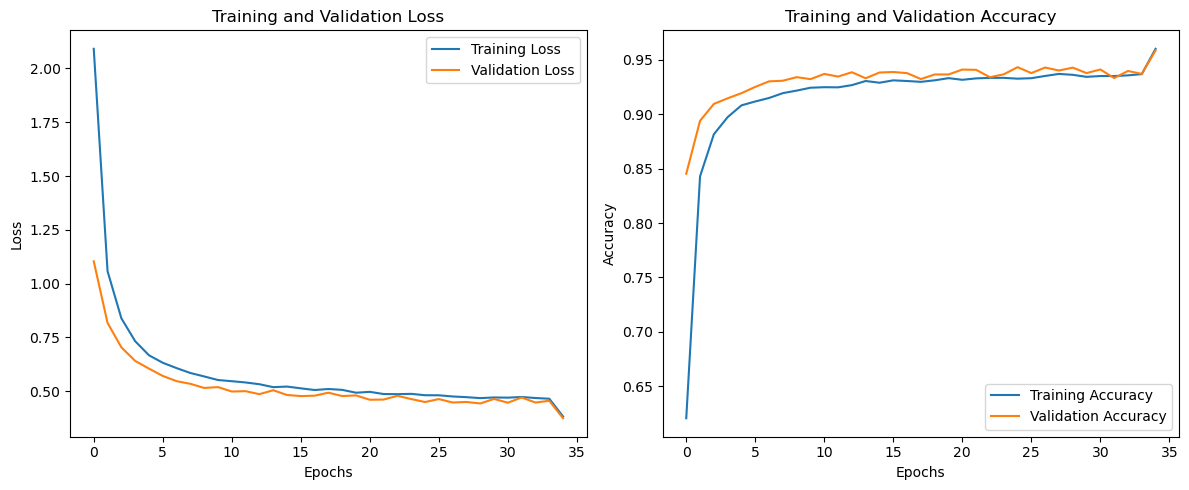

Training completed! Below, we summarize the results of the training process:
Final training accuracy: 0.9602
Final validation accuracy: 0.9587
Final training loss: 0.3823
Final validation loss: 0.3741

Results Comparison:
Non-Regularized Model - Validation Loss: 0.3089, Validation Accuracy: 0.9492
Regularized Model - Validation Loss: 0.3741, Validation Accuracy: 0.9587

The regularized model performs better on the validation set, indicating better generalization.


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create the regularized model with lighter regularization
model_reg = Sequential()

# Explicitly define the input layer
model_reg.add(Input(shape=(1092,)))  # The input has a dimension of 1092

# First dense layer (hidden layer) with L2 regularization and Dropout
model_reg.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization with a lower value
model_reg.add(Dropout(0.2))  # Reduced Dropout rate

# Second dense layer with L2 regularization and Dropout
model_reg.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization with a lower value
model_reg.add(Dropout(0.2))

# Third dense layer with L2 regularization and Dropout
model_reg.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization with a lower value
model_reg.add(Dropout(0.2))

# Fourth dense layer with L2 regularization
model_reg.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization with a lower value

# Output layer (softmax for multi-class classification)
model_reg.add(Dense(50, activation='softmax'))  # 50 classes

# Compile the model
model_reg.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric
)

# Summarize the model architecture
model_reg.summary()

# Define training parameters
batch_size = 256
epochs = 35

# Early stopping and ReduceLROnPlateau to improve convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with regularization
history_reg = model_reg.fit(
    x_train, y_train,  # Training data and labels
    validation_data=(x_test, y_test),  # Validation data
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=[ProgressBar(rolling_window=5), early_stopping, reduce_lr],  # Callbacks for monitoring
    verbose=0,  # 0 means no output during training
    shuffle=True,  # Shuffle the data at each epoch
)

# Display the loss and accuracy curves during training
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Summarize the training results
print("Training completed! Below, we summarize the results of the training process:")
print(f"Final training accuracy: {history_reg.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_reg.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history_reg.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history_reg.history['val_loss'][-1]:.4f}")

# Evaluate both models on the test data
val_loss_non_reg, val_accuracy_non_reg = model.evaluate(x_test, y_test, verbose=0)
val_loss_reg, val_accuracy_reg = model_reg.evaluate(x_test, y_test, verbose=0)

# Print the evaluation results for both models
print("\nResults Comparison:")
print(f"Non-Regularized Model - Validation Loss: {val_loss_non_reg:.4f}, Validation Accuracy: {val_accuracy_non_reg:.4f}")
print(f"Regularized Model - Validation Loss: {val_loss_reg:.4f}, Validation Accuracy: {val_accuracy_reg:.4f}")

# Compare the performance of the two models
if val_accuracy_reg > val_accuracy_non_reg:
    print("\nThe regularized model performs better on the validation set, indicating better generalization.")
else:
    print("\nThe non-regularized model performs better, indicating it may have overfitted to the training data.")

Based on the results obtained and analyzed during the training and the validation phases, what were your (rather _personal_) expectations with respect to the performances of your models on a blind external test set?

What are the differences between results on the validation set and the actual result on the test set (if any)? What could have caused them? Briefly motivate your answer.

After the comparison, what is the overall "best" model? Why?

For the model that you consider the "best", what are the major sources of error? Are there any classes/labels (or data samples in general) where the model is struggling the most? Why?

In [22]:
# TODO!

# 2. The development of a simple auto-encoder model  [Mandatory]
Implement a fully-connected AutoEncoder architecuture, with a **compression factor** (ratio between input size and smallest encoding size) in the **range [20-30]**.


Visually investigate the reconstruction abilities of such an architecture, e.g. comparing a few inputs and outputs (reconstructed inputs) of the model (as seen in class).

## 2.1 Building the network

note: although not strictly required, monitoring the training dynamics and performance evaluation is suggested for the autoencoder model.

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1092)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       559,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 40)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1092)           │       560,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,459,052 (5.57 MB)

 Trainable params: 1,459,052 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.1248 - mse: 0.1248 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.029

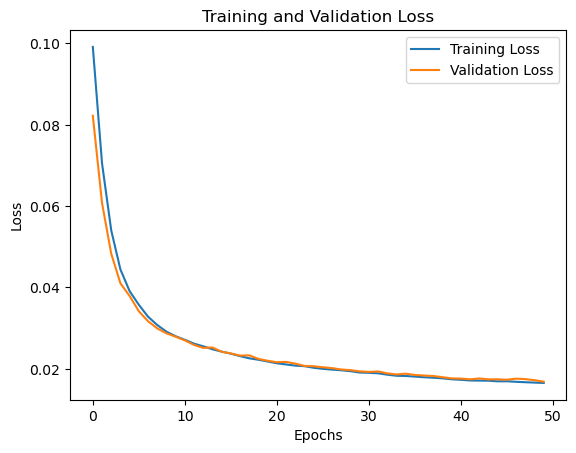

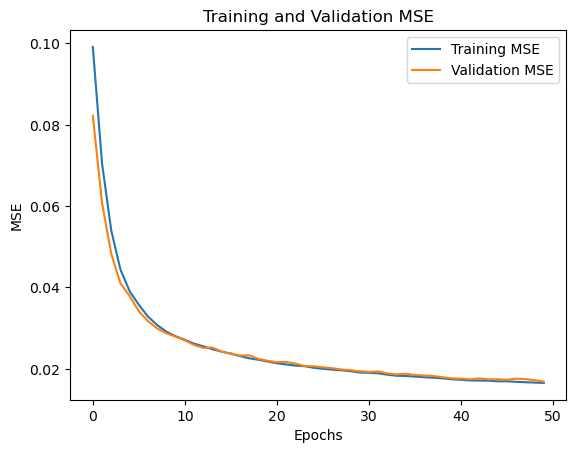

In [20]:
# Set the seed for reproducibility
from numpy.random import seed
import tensorflow as tf

# Chosen seed value for reproducibility
cherrypicked_seed = 1

# Set random seeds for numpy and TensorFlow to ensure reproducible results
seed(cherrypicked_seed)
tf.random.set_seed(cherrypicked_seed)

# Import necessary libraries
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Assume the dataset is similar to the one used previously in the model
# with training and test data preprocessed.

# Parameters for the autoencoder
input_dim = 1092  # Set input dimension, adjust based on your dataset
encoding_dim = 40  # Compression factor (chosen value between 20 and 30, e.g., 40)
activation = "relu"  # Activation function used in hidden layers

# Build the autoencoder

# Define the input layer
input_layer = Input(shape=(input_dim,))

# Encoder: progressively reduce the dimensionality of the input
encoded_1 = Dense(512, activation=activation)(input_layer)  # First encoding layer
encoded_2 = Dense(256, activation=activation)(encoded_1)  # Second encoding layer
encoded_3 = Dense(128, activation=activation)(encoded_2)  # Third encoding layer
encoded = Dense(encoding_dim, activation=activation)(encoded_3)  # Compressed encoding (smaller dimension)

# Decoder: reconstruct the original input from the encoded representation
decoded_1 = Dense(128, activation=activation)(encoded)  # First decoding layer
decoded_2 = Dense(256, activation=activation)(decoded_1)  # Second decoding layer
decoded_3 = Dense(512, activation=activation)(decoded_2)  # Third decoding layer
decoded = Dense(input_dim, activation='sigmoid')(decoded_3)  # Output layer (sigmoid to get values between 0 and 1)

# Create the autoencoder model (encoding and decoding)
autoencoder = Model(input_layer, decoded)

# Create the encoder model to visualize only the compression part
encoder_model = Model(input_layer, encoded)

# Create the decoder model (from the encoded representation to the reconstruction of the input)
decoder_model = Model(encoded, decoded)

# Summarize the autoencoder model's architecture
autoencoder.summary()

# Compile the autoencoder model
autoencoder.compile(optimizer="adam", loss='mse', metrics=['mse'])  # Use mean squared error (MSE) as the loss metric

# Train the autoencoder
history = autoencoder.fit(x_train, x_train,  # Autoencoder is trained with the same data as input and target
                          epochs=50,  # Set number of epochs
                          batch_size=1024,  # Set batch size for training
                          validation_data=(x_test, x_test),  # Use validation data (same input for target)
                          shuffle=True)  # Shuffle the data at each epoch for better training performance

# Plot the loss curve during training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the MSE curve during training
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 2.2 Visually Inspecting the results

Investigate the reconstruction capabilities of autoencoders by comparing (in a multi-column plot) the visual representation of some input data (5 to 10 samples) with the reconstruction of such samples (output of the autoencoder).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


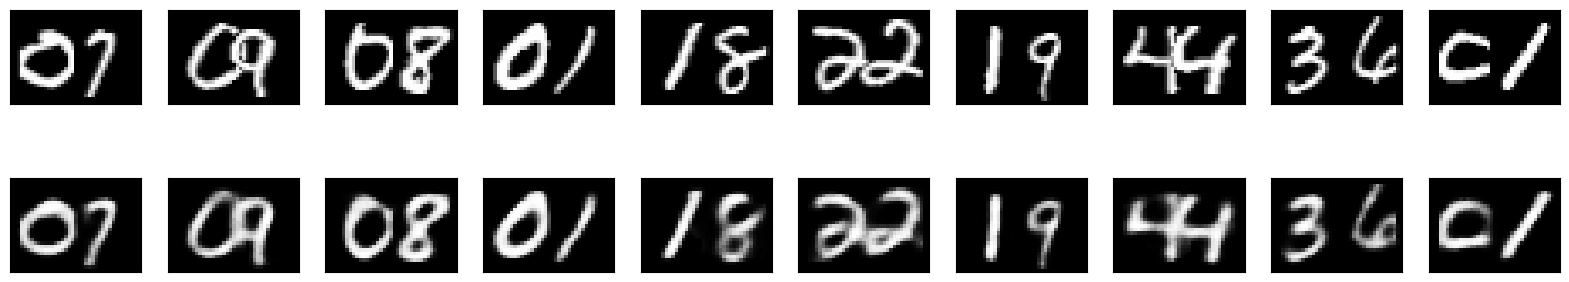

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Mean Absolute Error: 0.0508
Mean Squared Error: 0.0141


In [21]:
import matplotlib.pyplot as plt

# Select a subset of images from the test set
x_selected = x_test[:10]  # Select 10 images for analysis

# Obtain the encoded representation and the reconstruction from the autoencoder
encoded_imgs = encoder_model.predict(x_selected)
decoded_imgs = decoder_model.predict(encoded_imgs)

# Create a figure to visualize the results
plt.figure(figsize=(20, 4))

# Display both the original images and their reconstructed versions
for i in range(10):
    # Original image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_selected[i].reshape(28, 39))  # Reshaped to (28, 39) instead of (28, 28)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed image
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(28, 39))  # Reshaped to (28, 39) instead of (28, 28)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Calculate the reconstruction errors
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute the MAE and MSE for the reconstructed images
pred = autoencoder.predict(x_selected)

mae = mean_absolute_error(x_selected, pred)
mse = mean_squared_error(x_selected, pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

## 2.3 Generate new samples

Starting from random encodings, generate $N$ ($N \in [10,20]$) new samples, and make some comments about the quality and distribution of the generated samples.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


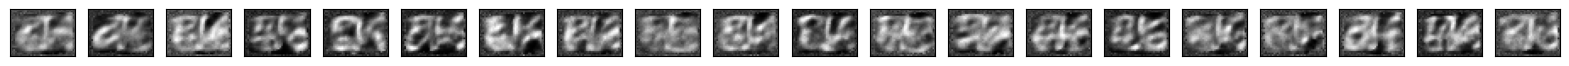

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Number of images to generate
n = 20

# Generate random encodings (latent space representations)
random_encodings = np.random.normal(size=(n, encoding_dim))  # Using a normal distribution for more realistic encodings

# Decode the random encodings to generate the images
decoded_imgs = decoder_model.predict(random_encodings)

# Visualize the generated images
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the generated images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 39))  # Recall the original shape of the images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 3.A [OPTIONAL] The use and evaluation of the latent (encoded) representations generated by the auto-encoder to solve the problem of supervised classification.

1. Obtain `X_train_encoded`, `X_test_encoded`, the latent (encoded) representations of `X_train` and `X_test` generated by the (encoder module of the) autoencoder developed in Section 2.

2. With the use of any classic machine learning method of your choice (avoid NNs), classify letters as in Sec.1 based on this representation.

3. Apply the same type of ML algorithm chosen in pt.2, but directly on the original data `X_train`, `X_test` (or you can use suitable dimensionality reduction methods if the chosen algorithm is known to require them or benefit from them).  

4. Compare (briefly) the performances on the test set, between the best model of Sec.1, the ML model trained on `X_train_encoded` and the ML model trained on `X_train` (or any other suitable representation that you choose in pt.3).


In other words, instead of feeding images directly through a classifier, you can try to use the encoded representations from the AE as input for a classic ML algorithm (XGB, SVM, RF ...) to solve the classification task.


2258/2258 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# 3.B [OPTIONAL] Explain model's predictions

Take the networks defined in (1) and try to explain the predictions of the model.

*   Include at least one model-agnostic method and one model-specific method;
*   Compare the two investigated XAI methods;
*   Compare the results on the original and regularized model for a single XAI method;

### 3.B.1 XAI method definition

Describe the design choices made at this stage: why did you choose these two methods?

### 3.B.2 Result's comparison

Compare the results of both XAI methods and the results of applying the same method to different models.